In [440]:
from time import time_ns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from torchvision import models
import matplotlib.pyplot as plt
import os
from glob import glob
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import requests
import tarfile
from sklearn.preprocessing import LabelEncoder
from win32con import DEVICE_DEFAULT_FONT
import time
from tqdm import tqdm
import copy

In [441]:
ROOT_FOLDER = os.getcwd()

In [442]:
print(ROOT_FOLDER)

C:\Users\zende\Jupyter


In [443]:
#train and test and val split
class DatasetSplitter:
    def __init__(self) -> None:
        data_path = os.path.join(ROOT_FOLDER, 'data', 'Stanford_dogs', 'Images')
        print(data_path)
        self.list_of_images = glob(os.path.join(data_path, '*', '*.jpg'))
        
        self.data_dict = {
            "image_paths": [],
            "labels" : []
        }
        
        self.data_df = None
        self.__prepare_dataset()
        
    def __prepare_dataset(self):
        
        for image_path in self.list_of_images:
            label = image_path.split(os.path.sep)[-2].split('-')[-1]
            self.data_dict['image_paths'].append(image_path)
            self.data_dict['labels'].append(label)
            
        self.data_df = pd.DataFrame(self.data_dict)
        # Shuffle the dataset
        self.data_df = (self.data_df.sample(frac=1, random_state=42).reset_index()).drop(columns="index")
        # encode the labels
        
        label_encoder = LabelEncoder()
        label_transformer = label_encoder.fit(self.data_df.labels.to_list())
        self.data_df['converted_labels'] = self.data_df.apply(lambda row: label_transformer.transform([row.labels])[0], axis=1)
        
    def __len__(self):
        return len(self.list_of_images)
    
    #split the dataset 
    
    def split_dataset(self):
        val_ratio = test_ratio = 0.2
        train, test = train_test_split(self.data_df, test_size=test_ratio, random_state=42)
        val, test = train_test_split(test, test_size=val_ratio, random_state=42)
        
        return train, val, test
        
        
        

In [444]:
dataset_splitter = DatasetSplitter()

C:\Users\zende\Jupyter\data\Stanford_dogs\Images


In [445]:
train, val, test = dataset_splitter.split_dataset()

In [446]:
train.shape

(16464, 3)

In [447]:
val.shape

(3292, 3)

In [448]:
test.shape

(824, 3)

In [449]:
train.head

<bound method NDFrame.head of                                              image_paths               labels  \
16375  C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...              clumber   
16615  C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...             Pembroke   
10098  C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...             bluetick   
7677   C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...  African_hunting_dog   
18717  C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...       French_bulldog   
...                                                  ...                  ...   
11284  C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...               kelpie   
11964  C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...     coated_retriever   
5390   C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...      standard_poodle   
860    C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...    Italian_greyhound   
15795  C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...   Kerry_blue_terrier  

In [450]:
train.labels.value_counts()

labels
coated_retriever      242
Maltese_dog           199
Scottish_deerhound    196
Afghan_hound          191
Samoyed               174
                     ... 
Rottweiler            114
otterhound            114
keeshond              113
groenendael           112
haired_pointer        110
Name: count, Length: 119, dtype: int64

In [451]:
val.labels.value_counts()

labels
coated_retriever        48
Maltese_dog             45
Tzu                     42
Bernese_mountain_dog    40
Lakeland_terrier        39
                        ..
cocker_spaniel          19
Scotch_terrier          18
chow                    17
komondor                16
dhole                   14
Name: count, Length: 119, dtype: int64

In [452]:
#splitting the dataset in X and Y
X_train, y_train = train['image_paths'], train['converted_labels']
X_val, y_val = val['image_paths'], val['converted_labels']
X_test, y_test = test['image_paths'], test['converted_labels']


In [453]:
X_train.head() 

16375    C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...
16615    C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...
10098    C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...
7677     C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...
18717    C:\Users\zende\Jupyter\data\Stanford_dogs\Imag...
Name: image_paths, dtype: object

In [454]:
y_train.head()

16375    85
16615    51
10098    78
7677      1
18717    25
Name: converted_labels, dtype: int32

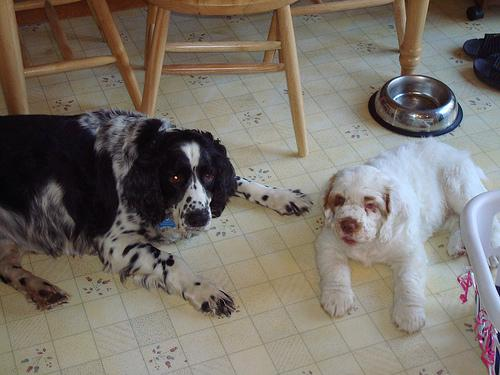

In [455]:
Image.open(X_train.iloc[0])

In [456]:
X_train.iloc[0]

'C:\\Users\\zende\\Jupyter\\data\\Stanford_dogs\\Images\\n02101556-clumber\\n02101556_4746.jpg'

In [457]:
#Creating the dataloader
class StanfordDogs(Dataset):
    def __init__(self, X_df: pd.DataFrame, Y_df: pd.DataFrame, transform=None, target_transform=None) -> None:
        super().__init__()
        
        self.transform = transform
        self.target_transform = target_transform

        self.X = X_df
        self.Y = Y_df
        
    def __getitem__(self, index):
        row = self.X.iloc[index]
        image = Image.open(row).convert('RGB')
        label = self.Y.iloc[index]
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, torch.tensor(label,dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    

In [458]:
dataset_train = StanfordDogs(X_train, y_train,
                             transform = Compose([
                                 Resize((224, 224)),
                                 ToTensor(),
                                 Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ]))

In [459]:
len(dataset_train)

16464

In [460]:
dataset_train.X.iloc[0]

'C:\\Users\\zende\\Jupyter\\data\\Stanford_dogs\\Images\\n02101556-clumber\\n02101556_4746.jpg'

In [461]:
image, label = dataset_train[30]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8081232..2.64].


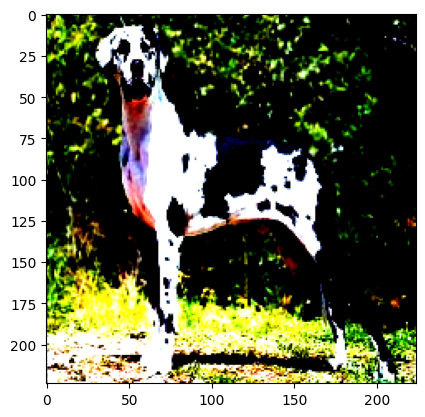

In [462]:
plt.imshow(image.permute(1,2,0))

In [463]:
dataset_val = StanfordDogs(X_val, y_val, 
                           transform= Compose([
                               Resize((224, 224)),
                               ToTensor(), 
                               Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               
                           ]))

In [464]:
image, label = dataset_val[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.622571].


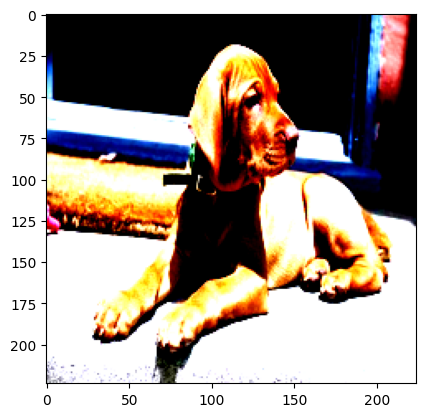

In [465]:
plt.imshow(image.permute(1,2,0))
plt.show()

In [466]:
#create dataloaders
train_dataloader = DataLoader(dataset_train, batch_size= 32, shuffle=True)

In [467]:
val_dataloader = DataLoader(dataset_val, batch_size=32, shuffle=True)

In [468]:
item, label = next(iter(train_dataloader))

In [469]:
item.shape

torch.Size([32, 3, 224, 224])

In [470]:
#model creation and training the models

num_classes = len(train.converted_labels.unique())


In [471]:
num_classes

119

In [472]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [473]:
device

device(type='cpu')

In [474]:
#pre-trained model
model = models.resnet18(pretrained=True)

In [475]:
#imagenet 1000 classes
#update output layer to match our number of classes

#only fine-tune
num_features = model.fc.in_features 


In [476]:
num_features

512

In [477]:
#update model final layer 
model.fc = nn.Linear(num_features, num_classes)

In [478]:
model.fc

Linear(in_features=512, out_features=119, bias=True)

In [479]:
model = model.to(device)

In [480]:
criteria_loss = nn.CrossEntropyLoss()

In [481]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [482]:
#dictionary of dataloaders
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
}

In [483]:
dataset_sizes = {
    'train': len(dataset_train),
    'val': len(dataset_val),
}

In [484]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x18528635d60>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x18528622a30>}

In [485]:
dataset_sizes

{'train': 16464, 'val': 3292}

In [486]:



#function to train the model
def train(model, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        #Each epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over the data
            print(f'Current phase is --> {phase}')
            with tqdm(dataloaders[phase], unit='batch') as tepoch:
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    #zero out the parameter gradients
                    
                    optimizer.zero_grad()
                    
                    #forward step
                    #track history only if training phase
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        #perform back prop and update weight only in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - start_time
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val acc: {best_acc:4f}')
    
    #Load best weights
    model.load_state_dict(best_model_weights)
    return model

In [ ]:
trained_model = train(model, criteria_loss, optimizer, num_epochs=25)

Epoch 0/24
----------
Current phase is --> train


 58%|█████▊    | 300/515 [10:06<07:03,  1.97s/batch]